# Extract and Visualize Gradient Attribution

In [32]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm
from datasets import load_from_disk
import torch

from IPython.display import HTML

from captum.attr import Saliency, IntegratedGradients
from captum.attr import visualization as viz

## Data

In [2]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_inputs(example):
    return tokenizer(example['text'], truncation=True, return_tensors='pt')

ds = load_from_disk('../data/ellipse.hf/test').map(tokenize_inputs, remove_columns=['text'])

Loading cached processed dataset at /home/jovyan/active-projects/ellipse-methods-showcase/data/ellipse.hf/test/cache-4be22a2c846c3238.arrow


## Models

In [3]:
grammar_model = AutoModelForSequenceClassification.from_pretrained(f'../bin/grammar-model/').cuda()
grammar_model.eval()

vocab_model = AutoModelForSequenceClassification.from_pretrained(f'../bin/vocabulary-model/').cuda()
vocab_model.eval()
print()

### A note on BERT's tokenization scheme

In [4]:
for token_type, token_str in tokenizer.special_tokens_map.items():
    print(f'{token_type: <10}: {token_str: <6} | {tokenizer.encode(token_str, add_special_tokens=False)[0]:>3}')

unk_token : [UNK]  | 100
sep_token : [SEP]  | 102
pad_token : [PAD]  |   0
cls_token : [CLS]  | 101
mask_token: [MASK] | 103


## Helper Functions

In [5]:
def forward_func(input_embedding, model=None):
    '''This is just a wrapper around the model's __call__ method.
    It returns the output logit (the predicted score) directly.
    '''
    return model(inputs_embeds=input_embedding).logits

In [6]:
def construct_whole_bert_embeddings(input_ids, model=grammar_model):
    '''We cannot calculate gradients with respect to the input ids
    because they are discrete, we need to calculate them with respect
    to the input embeddings, which are vectors of 768 values for each 
    token. Under normal circumstances, we can let the model handle
    this step silently, but we need to do it manually for interpretation.
    
    Either model would produce the same embeddings. This layer is not
    trained.
    '''
    input_embeddings = model.bert.embeddings(input_ids)    
    return input_embeddings

In [20]:
def construct_baseline(input_ids):
    '''We establish a baseline to compare against, like an input that is all zeroes.
    Here, I create a tensor of the same length as the input but made up
    entirely of [MASK] tokens. Different baselines are possible.'''
    baseline = [101] # [CLS]
    baseline.extend([103] * (len(input_ids) - 2)) # [MASK]
    baseline.append(102) # [SEP]

    return construct_whole_bert_embeddings(
        torch.tensor([baseline], dtype=int).cuda()
    )

In [22]:
def get_attributions(embedding, baseline, model):
    return ig.attribute(
        inputs=embedding,
        baselines=(baseline),
        additional_forward_args=model,
        return_convergence_delta=True)

In [27]:
def summarize_attributions(attributions):
    '''Sums the attributions for each token embedding
    and normalizes the token attributions.
    '''
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions) # vector norm

    return attributions

## Integrated Gradients

In [28]:
# Captum function for calculating saliency attributions
ig = IntegratedGradients(forward_func)

# Container for VisualizationDataRecords
viz_records = []

for sample in tqdm(ds.shuffle().select(range(10))):
    # We will use this dict to store information necessary to visualize the results
    viz_dict = {}
    
    # Get the actual scores
    viz_dict['grammar_true'] = round(sample.pop('Grammar'), 2)  
    viz_dict['vocab_true'] = round(sample.pop('Vocabulary'), 2)  

    # Get the text identifier in case we see something interesting
    viz_dict['text_id'] = sample.pop('text_id')
    
    # Get the plain text version of the tokens (but leave them separated by spaces)
    input_ids = sample['input_ids']
    viz_dict['tokens'] = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Push input_ids to GPU
    input_ids = torch.tensor(input_ids).cuda()

    # We need to create the embeddings manually so we can track their gradients
    manual_embed = construct_whole_bert_embeddings(input_ids)

    # Construct a baseline input
    baseline = construct_baseline(input_ids[0])


    # Calculate the predicted score separately, because the Captum module does not output it.
    with torch.no_grad():    
        grammar_pred = forward_func(manual_embed, grammar_model)[0]
        vocab_pred = forward_func(manual_embed, vocab_model)[0]
        viz_dict['grammar_pred'] = round(grammar_pred.item(), 2)
        viz_dict['vocab_pred'] = round(vocab_pred.item(), 2)

    attributions, delta = get_attributions(manual_embed, baseline, grammar_model)
    viz_dict['grammar_attributions'] = summarize_attributions(attributions)
    viz_dict['grammar_delta'] = round(delta.item(), 2)

    attributions, delta = get_attributions(manual_embed, baseline, vocab_model)
    viz_dict['vocab_attributions'] = summarize_attributions(attributions)
    viz_dict['vocab_delta'] = round(delta.item(), 2)

    viz_records.append(viz_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

## Publication-ready Visualizations

In [48]:
# Visualization
%matplotlib inline
#display figures the same way they will be saved.
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
import seaborn as sns
sns.set_theme(style="white")

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import transforms
from mpl_toolkits import axes_grid1

plt.rcParams.update({
    'figure.dpi': 300,
    "font.family": "serif",
})


class TextHeatmap:
    """
    Optionally prints a dispersion map and matplotlib colorbar.
    ---
    tokens: list of strings
    attributions: list of importance scores, same length as tokens
    width: inches
    """
    def __init__(self,
                 tokens,
                 attributions,
                 width=7.5,
                 fontsize=11,
                 fontname='DejaVu Sans Mono',
                 dpi=300,
                 disp_colorbar=False,
                 disp_dispersion=False):
        
        self.tokens = tokens
        self.attributions = attributions
        self.figsize_x = width
        self.fontsize = fontsize
        self.fontname = fontname
        self.colormap = mpl.cm.RdBu
        self.norm = mpl.colors.Normalize(vmin=-0.5, vmax=0.5)
        self.dpi = dpi
        self.disp_colorbar = disp_colorbar
        self.disp_dispersion = disp_dispersion
        self.text_w = 0.85 * width * self.dpi # 85% of width
        
    def _draw_token(self, ax, token):
        '''Draws a token on the axis object
        '''
        self.text = ax.text(0.01,
                                 1,
                                 token,
                                 transform=self.trans,
                                 fontname=self.fontname,
                                 fontsize=self.fontsize,
                                 bbox=self.bbox)
        
        self.text.draw(self.artist)
        self.ex = self.text.get_window_extent()
        self.trans = transforms.offset_copy(
            self.text.get_transform(),
            x = self.ex.width + self.fontsize,
            units='dots')
    
    def _prepare_figure(self):
        '''Prepares the figure and axes
        '''
        self.fig, self.axs = plt.subplots(figsize=(self.figsize_x, 5), dpi=self.dpi, facecolor='None')
        if title is not None:
            self.fig.suptitle(title, fontsize=self.fontsize + 2)

        self.ax = self.fig.add_subplot()
        self.ax.set_axis_off()
        self.divider = axes_grid1.make_axes_locatable(self.ax)

        self.y = 0 # where to start drawing words
        self.ex = None
        self.trans = self.ax.transData
        self.artist = self.ax.figure.canvas.get_renderer()

    def display(self, title=None, savefile=None):
        self._prepare_figure()
        # Draw words
        for token, attribution in zip(self.tokens, self.attributions):
            self.bbox={
                'facecolor': self.colormap(self.norm(attribution)),
                'alpha': 0.6,
                'edgecolor': 'white',
                'pad': 1,
                'snap': True
            }
            self._draw_token(token)

            # remove text outside of text_w
            # redraw on next line
            if self.ex.x1 > self.text_w:
                self.text.remove() 
                self.y -= self.ex.height + self.fontsize
                self.trans = transforms.offset_copy(
                    ax.transData,
                    y=self.y,
                    units='dots')
                self._draw_token(ax, token)

        self.y -= self.ex.height*4
        self.text_h = (abs(self.y)) / self.dpi

        if self.disp_dispersion:
            self.fig.set_figheight(self.text_h + 1)
            self.disp_bar = self.divider.append_axes("bottom", size=.8, pad=0)
            self.disp_bar.set_axis_off()
            self.img = np.array(self.attributions).reshape(1, -1)
            cax = self.disp_bar.inset_axes([0.01, 0.5, .95, .3], transform=self.disp_bar.transAxes)
            cax.pcolor(self.img,
                       cmap=self.colormap.with_extremes(under='None'),
                       vmin=0,
                       vmax=1,
                       edgecolors='k',
                       linewidths=.1)
            cax.get_yaxis().set_visible(False)
            cax.set_xlabel(f'Tokens (N={len(self.attributions)})')
        else:
            self.fig.set_figheight(self.text_h)

        if self.disp_colorbar:
            self.cax = self.divider.append_axes('right', size=.10, pad=0)
            self.fig.colorbar(mpl.cm.ScalarMappable(norm=self.norm, cmap=self.colormap),
                              cax=self.cax,
                              ticks=[self.norm.vmin, 0, self.norm.vmax],
                              alpha=.5)
            
        if savefile is None:
            plt.show()
            self.fig.tight_layout()
        else:
            plt.savefig(savefile)
        plt.close()

In [120]:
tokens = viz_records[0]['tokens']
attribution_dict = {'grammar': viz_records[0]['grammar_attributions'].detach().cpu().numpy(),
                    'vocabulary': viz_records[0]['vocab_attributions'].detach().cpu().numpy()}

In [53]:
for i, j in zip(attributions, range(2)):
    print(j)

0
1


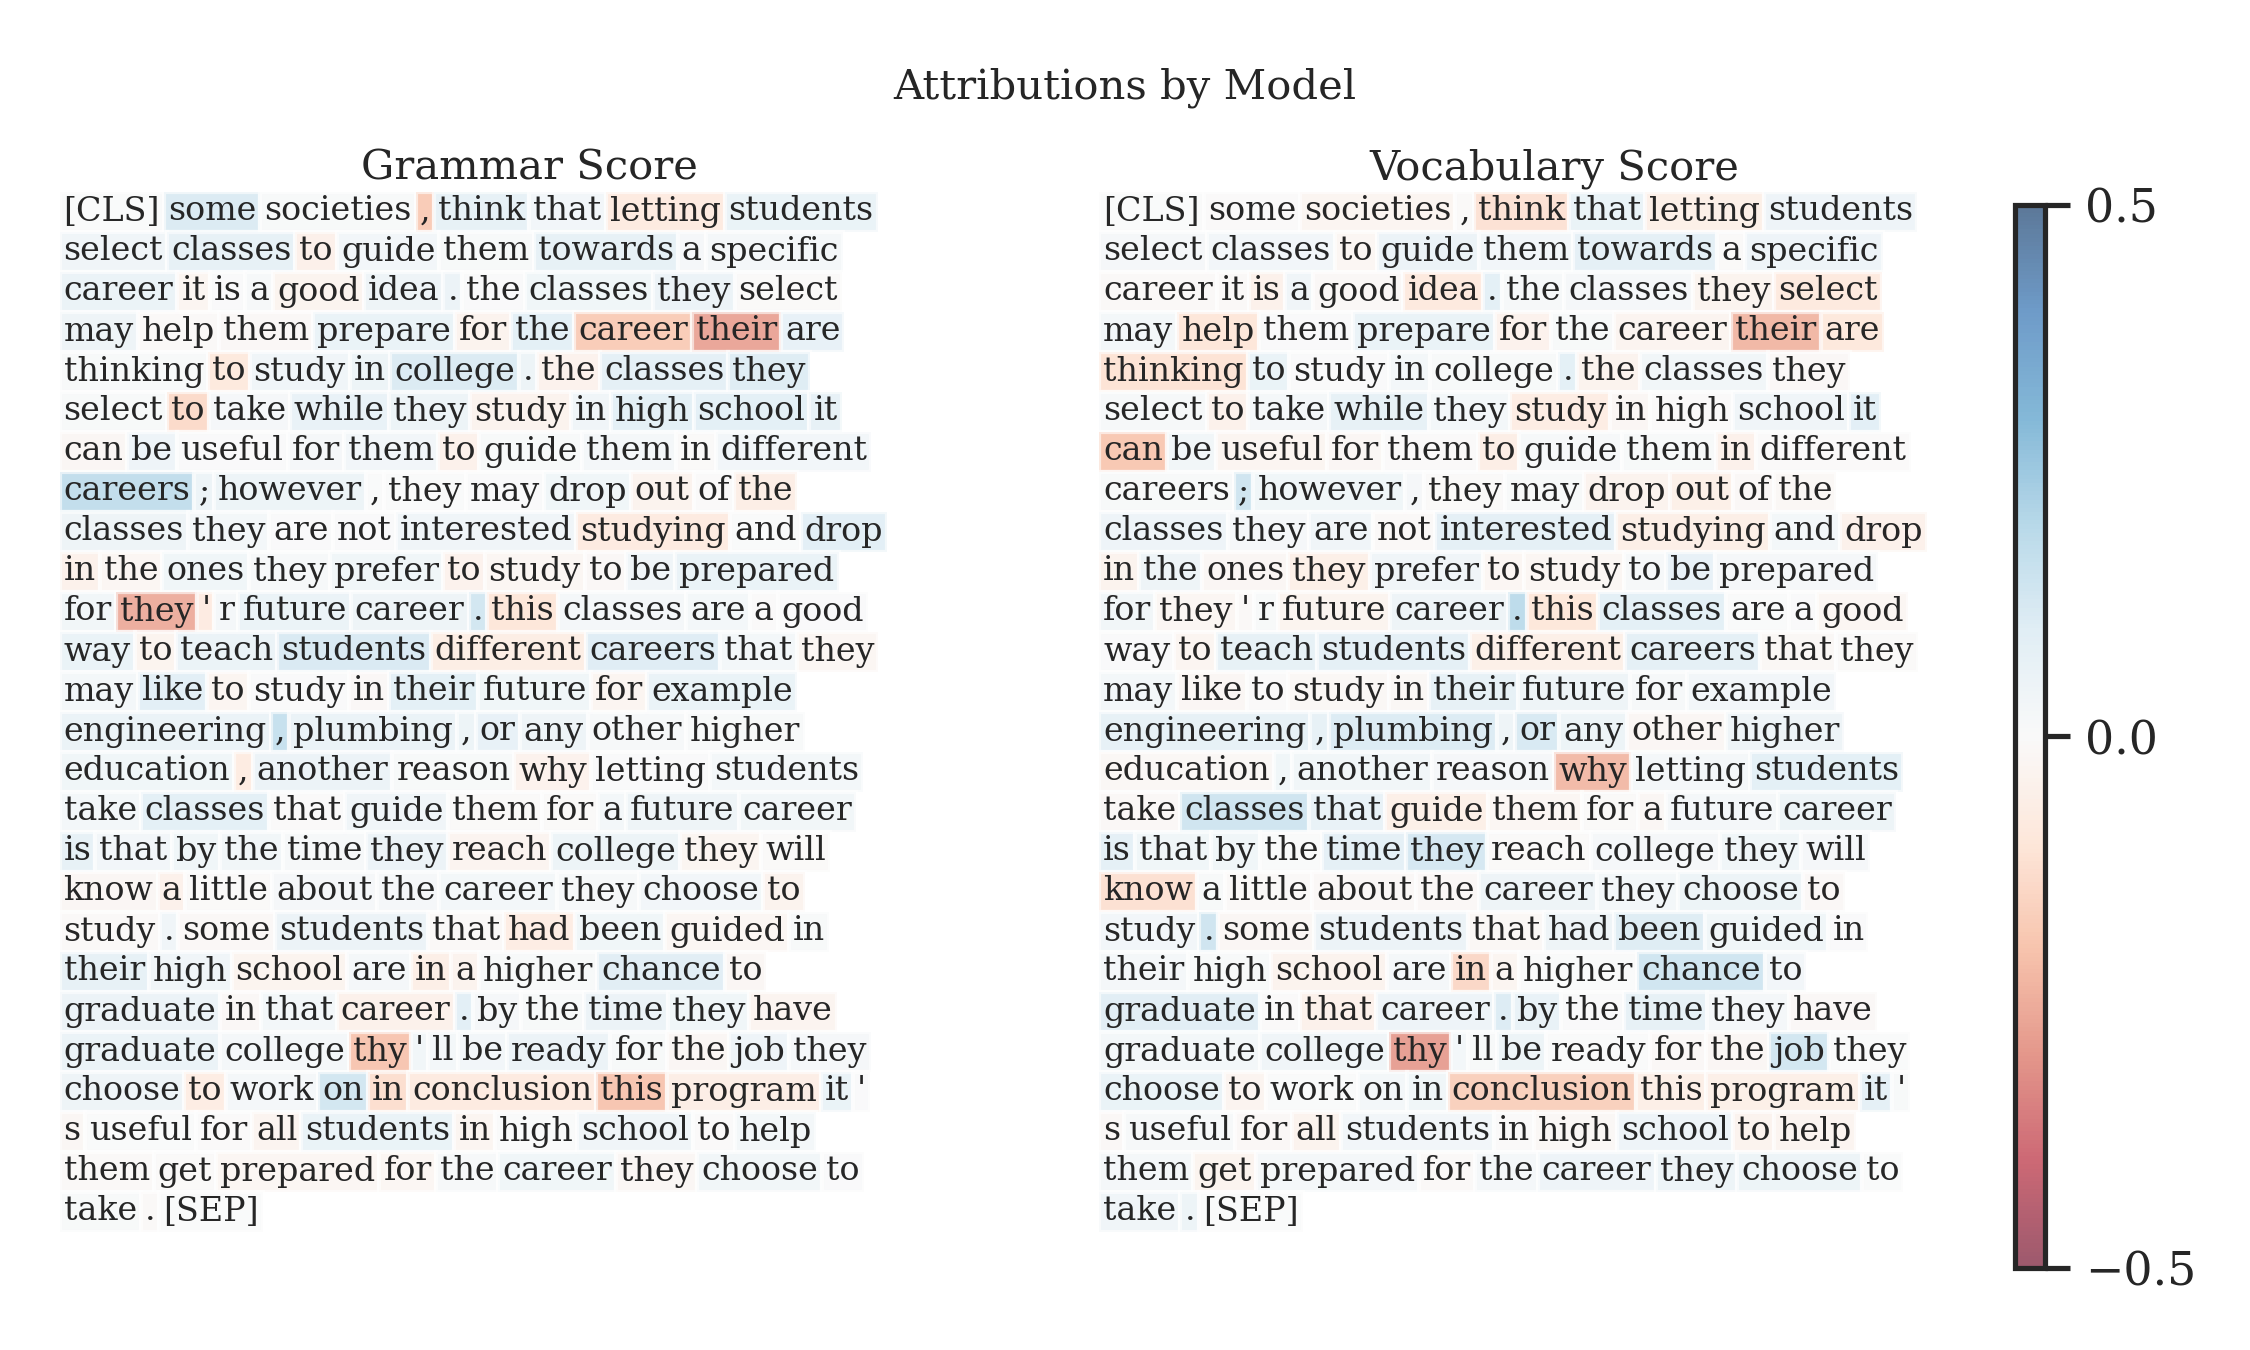

In [132]:
fig, axs = plt.subplots(ncols=2, figsize=(7.5, 4.5), dpi=300, facecolor='None', layout='tight')
fig.suptitle('Attributions by Model', fontsize=10, y=0.95)
artist = fig.canvas.get_renderer()
colormap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.5, vmax=0.5)
fontsize = 8

def draw_token(ax, token, transform, bbox):
    text = ax.text(0.01,
                   1,
                   token,
                   transform=transform,
                   # fontname=self.fontname,
                   fontsize=fontsize,
                   bbox=bbox)

    text.draw(artist)
    ex = text.get_window_extent()
    transform = transforms.offset_copy(
        text.get_transform(),
        x = ex.width + fontsize,
        units='dots')
    
    return ex, text, transform

for score, ax in zip(attribution_dict, axs):
    attributions = attribution_dict[score]
    ax.set_title(f'{score.capitalize()} Score', fontsize=10)

    text_width = ax.get_tightbbox().x1
    ax.set_axis_off() # do not display the x- or y-axis.
    ax.axis('off')
    divider = axes_grid1.make_axes_locatable(ax)
    y = -fontsize*2 # where to start drawing words
    transform = transforms.offset_copy(
        ax.transData,
        y=y,
        units='dots')
    
    # loop over tokens
    for token, attribution in zip(tokens, attributions):
        bbox={
            'facecolor': colormap(norm(attribution)),
            'alpha': 0.6,
            'edgecolor': 'white',
            'pad': 1,
            'snap': True
        }

        ex, text, transform = draw_token(ax, token, transform, bbox)
        # remove text outside of text_w
        # redraw on next line
        if ex.x1 > text_width:
            text.remove() 
            y -= ex.height + fontsize
            transform = transforms.offset_copy(
                ax.transData,
                y=y,
                units='dots')

            ex, text, transform = draw_token(ax, token,
                                  transform, bbox)

cax = divider.append_axes('right', size=.10, pad=0)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap),
             cax=cax,
             ticks=[norm.vmin, 0, norm.vmax],
             alpha=.65)
plt.show()
plt.close()